In [1]:
import sys
sys.path.append('../')

# https://platform.openai.com/docs/guides/vision
from openai import OpenAI
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

import open3d as o3d
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import RealSense as real

# Initialize RS435i connection
rsc = real.RealSense()
rsc.initConnection()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Import OWL-ViT
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [3]:
def retrieve_mask_from_image_crop(box, full_o3d_image):
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    # y_min = int(box[0])
    # x_min = int(box[1])
    # y_max = int(box[2])
    # x_max = int(box[3])
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    bbox = x_min, y_min, x_max, y_max

    # mask out bounding box in img
    depth_image = np.asarray(full_o3d_image.depth)
    # depth_values = depth_image[x_min:x_max, y_min:y_max]
    depth_values = depth_image[y_min:y_max, x_min:x_max]
    depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
    rgb_image    = np.asarray(full_o3d_image.color)
    # rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
    rgb_values = np.asarray(full_o3d_image.color)[y_min:y_max, x_min:x_max]
    rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

    cropped_o3d_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)

    # Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

    # Create masks for the region of interest
    roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
    # roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
    roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

    roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
    # roi_mask_depth[x_min:x_max, y_min:y_max] = True
    roi_mask_depth[y_min:y_max, x_min:x_max] = True

    rgb_m_array = rgb_image
    depth_m_array = depth_image
    # Apply the masks to set values outside the ROI to 0
    rgb_m_array[~roi_mask_rgb] = 255
    depth_m_array[~roi_mask_depth] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))
    
    rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)
    
    return depth_m, rgb_m, rgbd_m_image

In [189]:
pcd,rgbdImage = rsc.getPCD()

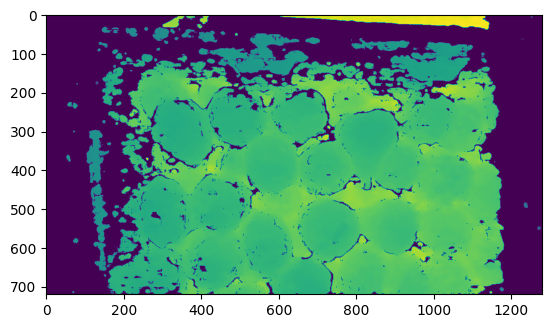

In [190]:
plt.imshow(rgbdImage.depth)

In [191]:
m = np.array(masks[5][0], dtype=bool)
depth_m_array = np.asarray(rgbdImage.depth)
depth_m_array[~m] = 0

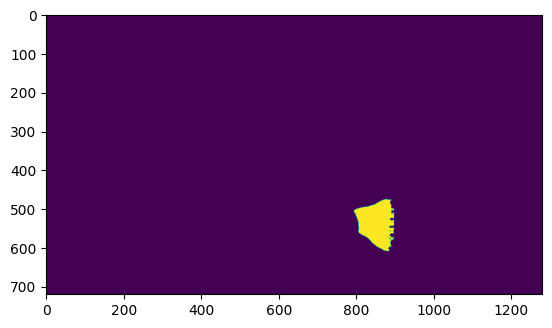

In [192]:
plt.imshow(m)

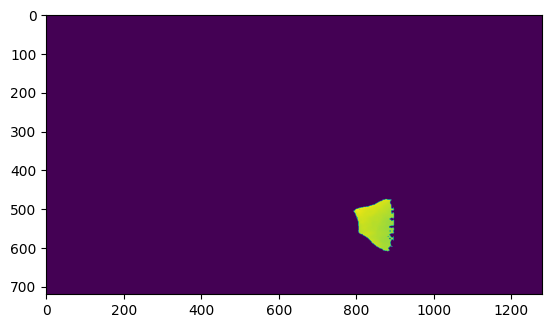

In [194]:
plt.imshow(rgbdImage.depth)

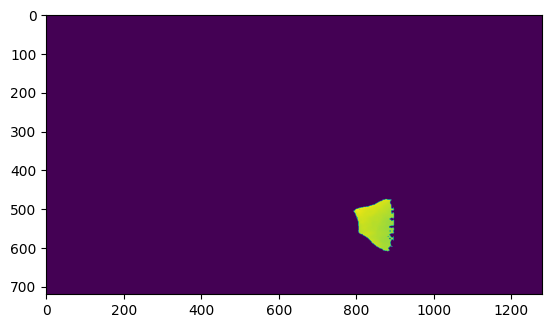

In [193]:
plt.imshow(depth_m_array)

In [195]:
def create_depth_mask_from_mask(mask, orig_depth):
    '''
    @param mask np.array of item mask
    @param orig_depth Open3D Image
    '''
    # depth_m_array = np.zeros_like(np.asarray(orig_depth))
    depth_m_array = np.asarray(orig_depth)
    depth_m_array[~mask] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    return depth_m

In [4]:
def crop_and_denoise_pcd(depth_m, orig_pcd):
    ###
    # This is the magic line
    # find the depth mask from the OWL ViT bounding box
    # reassign the orig rgbdImage
    # then recreate the pcd
    ###
    orig_pcd.depth = depth_m
    # et voila
    cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        orig_pcd,
        # rgbd_m_image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True,
        extrinsic=rsc.extrinsics
    )

    # denoise pcd
    cl, ind = cpcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.01)
    inlier_cloud = cpcd.select_by_index(ind)
    # display_inlier_outlier(saved_pcd, ind)
    # displayWorld(inlier_cloud)

    mc = inlier_cloud.compute_mean_and_covariance()
    return inlier_cloud, mc

In [13]:
# Helper Functions

# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    uboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
      uboxes.append((box, text_queries[label]))
    return pboxes, uboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.figure(figsize=(10, 10))
    # ax.imshow(input_image)
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    
    idx = 0
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]} ({idx}): {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
      idx += 1

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [94]:
# take RealSense picture and run OWL-ViT inference
pcd,rgbdImage = rsc.getPCD()
img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
img = np.asarray(rgbdImage.color)

[385.6759262084961, 164.52411264181137, 470.19336700439453, 246.2139692902565]
[740.0773620605469, 243.34813356399536, 911.5647888183594, 421.81575536727905]
[428.8240432739258, 332.5636410713196, 525.8879470825195, 427.17485189437866]
[500.095534324646, 302.08431601524353, 652.3811960220337, 451.7212164402008]
[1051.6605949401855, 386.81990683078766, 1197.2976875305176, 530.0700277090073]
[772.5517797470093, 481.3260179758072, 907.7823877334595, 596.0834401845932]
[787.3609256744385, 469.79141414165497, 961.9226741790771, 614.6997624635696]
[328.7526345252991, 539.0259557962418, 408.5276389122009, 622.7013391256332]
[1058.226399421692, 531.1344784498215, 1210.5342817306519, 686.5367442369461]
[646.5915298461914, 617.7030372619629, 757.8803634643555, 719.7284317016602]
[574.9168014526367, 618.3064270019531, 741.9192886352539, 720.0344181060791]


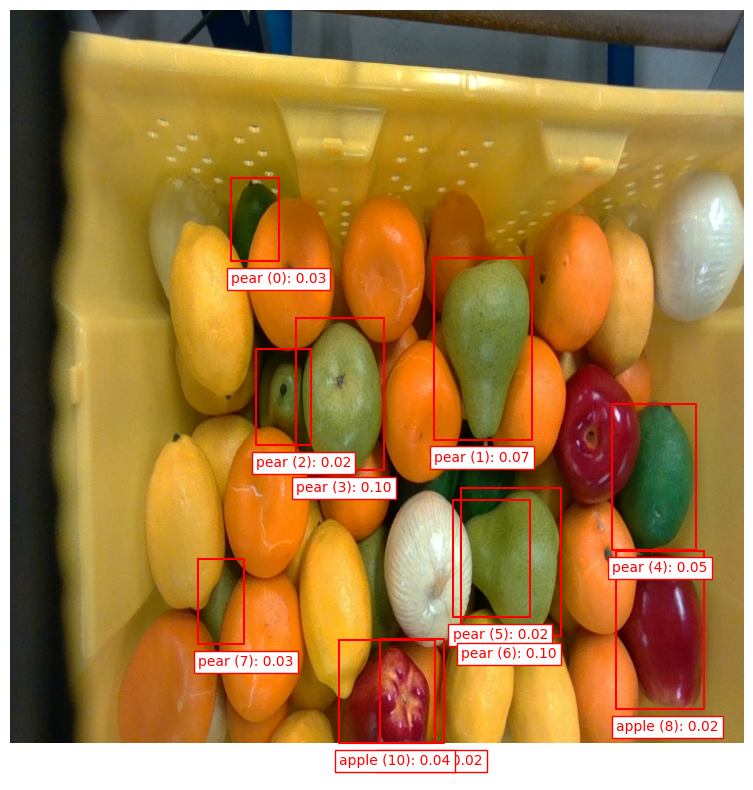

<Figure size 1000x1000 with 0 Axes>

In [99]:
# run image through OWL-ViT
# texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
texts = ["a photo of a red apple", "a photo of a bright yellow lemon", "a photo of a dark green lime", "a photo of a light green pear"]
# texts = [ "a photo of red cube", "a photo of a blue cube", "a photo of a yellow cube"]
# texts = ["apple", "lemon", "lime", "pear"]
inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.Tensor([img.shape[:2][::-1]])

# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
# text_queries = ["apple", "lemon", "lime", "pear", "onion"]
# text_queries = ["r", "b", "y"]
text_queries = ["apple", "lemon", "lime", "pear"]
THRESHOLD = 0.021
# plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
plot_predictions(img, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
bboxes, uboxes = get_boxes(img, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)


In [100]:
bboxes

[([385.6759262084961,
   164.52411264181137,
   470.19336700439453,
   246.2139692902565],
  'pear'),
 ([740.0773620605469,
   243.34813356399536,
   911.5647888183594,
   421.81575536727905],
  'pear'),
 ([428.8240432739258,
   332.5636410713196,
   525.8879470825195,
   427.17485189437866],
  'pear'),
 ([500.095534324646, 302.08431601524353, 652.3811960220337, 451.7212164402008],
  'pear'),
 ([1051.6605949401855,
   386.81990683078766,
   1197.2976875305176,
   530.0700277090073],
  'pear'),
 ([772.5517797470093, 481.3260179758072, 907.7823877334595, 596.0834401845932],
  'pear'),
 ([787.3609256744385,
   469.79141414165497,
   961.9226741790771,
   614.6997624635696],
  'pear'),
 ([328.7526345252991, 539.0259557962418, 408.5276389122009, 622.7013391256332],
  'pear'),
 ([1058.226399421692,
   531.1344784498215,
   1210.5342817306519,
   686.5367442369461],
  'apple'),
 ([646.5915298461914, 617.7030372619629, 757.8803634643555, 719.7284317016602],
  'apple'),
 ([574.9168014526367, 61

In [101]:
pcd,rgbdImage = rsc.getPCD()
# index corresponds to (<num>) following label name of bounding boxes in above annotated image
index = 5
dm, rm, imgm = retrieve_mask_from_image_crop(bboxes[index][0], rgbdImage)
cpcd, mc = crop_and_denoise_pcd(dm, rgbdImage)
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
print(grasp_pose)
# displayWorld(cpcd)

[0.0984190124843241, -0.11715287803290539, 0.349943822995787]


In [142]:
np.array(masks[5][0][0])

array([False, False, False, ..., False, False, False])

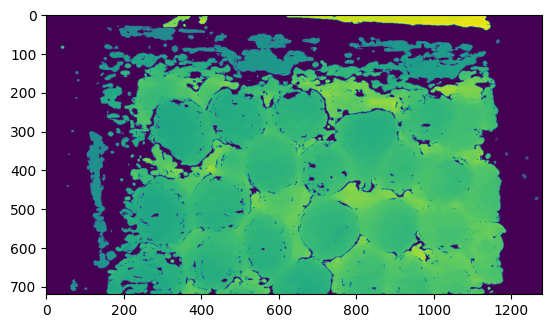

In [196]:
pcd,rgbdImage = rsc.getPCD()
plt.imshow(rgbdImage.depth)

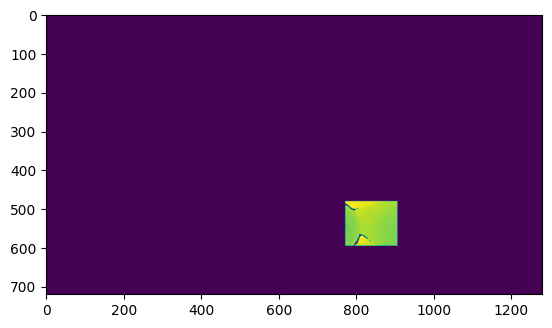

In [197]:
plt.imshow(dm)

In [198]:
mdm = create_depth_mask_from_mask(np.array(masks[5][0]), rgbdImage.depth)

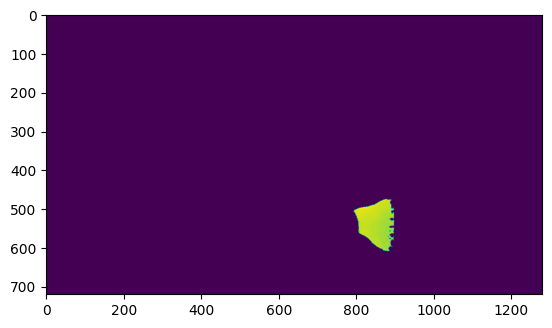

In [199]:
plt.imshow(mdm)

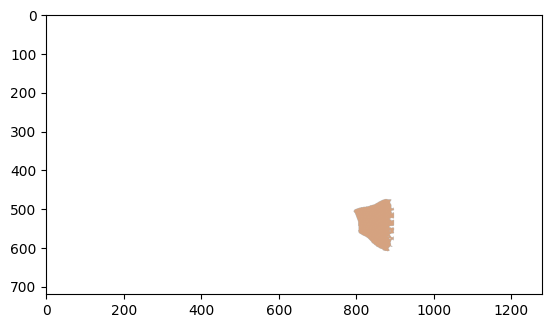

In [151]:
show_mask(masks[5].cpu().numpy(), plt.gca(), random_color=True)

In [200]:
pcd,rgbdImage = rsc.getPCD()
mcpcd, mmc = crop_and_denoise_pcd(mdm, rgbdImage)

In [201]:
displayWorld(mcpcd)

In [20]:
# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import copy

predictor = SamPredictor(build_sam(checkpoint="/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"))

In [22]:
dims = target_sizes[0].numpy().astype(dtype=int)

In [103]:
# USE THIS
boxes = np.array([np.array(i[0]) for i in bboxes])
# DO NOT USE
# boxes_swap = copy.deepcopy(boxes)
# boxes_swap[:,0] = boxes_swap[:,1]
# boxes_swap[:,1] = boxes[:, 0]
# storage = boxes[:, 2]
# boxes_swap[:,2] = boxes_swap[:,3]
# boxes_swap[:,3] = boxes[:, 2]
# boxes_swap

array([[ 164.52411264,  385.67592621,  246.21396929,  470.193367  ],
       [ 243.34813356,  740.07736206,  421.81575537,  911.56478882],
       [ 332.56364107,  428.82404327,  427.17485189,  525.88794708],
       [ 302.08431602,  500.09553432,  451.72121644,  652.38119602],
       [ 386.81990683, 1051.66059494,  530.07002771, 1197.29768753],
       [ 481.32601798,  772.55177975,  596.08344018,  907.78238773],
       [ 469.79141414,  787.36092567,  614.69976246,  961.92267418],
       [ 539.0259558 ,  328.75263453,  622.70133913,  408.52763891],
       [ 531.13447845, 1058.22639942,  686.53674424, 1210.53428173],
       [ 617.70303726,  646.59152985,  719.7284317 ,  757.88036346],
       [ 618.306427  ,  574.91680145,  720.03441811,  741.91928864]])

In [104]:
# boxes = np.array([i[0] for i in uboxes])
# boxes = pboxes.detach().numpy()
normalized_boxes = copy.deepcopy(boxes_swap)
H, W = dims[1], dims[0]
boxes = torch.tensor(boxes)
labels = np.array([i[1] for i in uboxes])
size = [H, W]
pred_dict = {
    # "boxes": normalized_boxes,
    "boxes": boxes,
    "size": [size[1], size[0]], # H, W
    "labels": labels
}

In [105]:
pcd,rgbdImage = rsc.getPCD()


In [106]:
rgb_array = (np.array(rgbdImage.color))
cv2_array = rgb_array[:, :, ::-1].copy()
image = cv2.cvtColor(cv2_array, cv2.COLOR_RGB2BGR)
# pil_img = Image.fromarray(rgb_array)


In [107]:
predictor.set_image(image)

In [108]:
i_image = predictor.transform.apply_image(image)
i_image_torch = torch.as_tensor(input_image)
i_image_torch = i_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]


In [109]:
[img.shape[:2][::-1]]

[(1280, 720)]

In [110]:
# DO THIS
# need to copy bboxes, not boxes...
boxes_copy = np.array([np.array(i[0]) for i in bboxes])

In [111]:
boxes = copy.deepcopy(boxes_copy)

In [112]:
boxes_copy = torch.tensor(copy.deepcopy(boxes))

In [113]:
boxes_copy

tensor([[ 385.6759,  164.5241,  470.1934,  246.2140],
        [ 740.0774,  243.3481,  911.5648,  421.8158],
        [ 428.8240,  332.5636,  525.8879,  427.1749],
        [ 500.0955,  302.0843,  652.3812,  451.7212],
        [1051.6606,  386.8199, 1197.2977,  530.0700],
        [ 772.5518,  481.3260,  907.7824,  596.0834],
        [ 787.3609,  469.7914,  961.9227,  614.6998],
        [ 328.7526,  539.0260,  408.5276,  622.7013],
        [1058.2264,  531.1345, 1210.5343,  686.5367],
        [ 646.5915,  617.7030,  757.8804,  719.7284],
        [ 574.9168,  618.3064,  741.9193,  720.0344]], dtype=torch.float64)

In [114]:
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_copy, img.shape[:2][::-1])

In [30]:
### DONT DO THIS
# storage = boxes[:,0]
# boxes_copy[:,0] = boxes_copy[:,1]
# boxes_copy[:,1] = boxes[:, 0]
# storage = boxes[:, 2]
# boxes_copy[:,2] = boxes_copy[:,3]
# boxes_copy[:,3] = boxes[:, 2]
# boxes_copy

tensor([[   3.3103,  190.7015,  124.2755,  232.5894],
        [  98.5397,  384.8799,  435.7823,  479.3557],
        [ 273.2642,  242.8950,  542.4848,  329.9553],
        [ 550.4420,  559.8619,  810.3098,  636.0638],
        [  14.1940,   42.4066, 1289.6747,  719.6421]])

In [117]:
### DONT DO THIS
# transformed_boxes = transformed_boxes * 1.25

In [115]:
masks, _, _ = predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = transformed_boxes,
    multimask_output = False,
)

In [116]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [124]:
from PIL import Image, ImageDraw, ImageFont

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    # y0, x0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    # h, w = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def plot_boxes_to_image(image_pil, tgt):
    H, W = tgt["size"]
    boxes = tgt["boxes"]
    labels = tgt["labels"]
    assert len(boxes) == len(labels), "boxes and labels must have same length"

    draw = ImageDraw.Draw(image_pil)
    mask = Image.new("L", image_pil.size, 0)
    mask_draw = ImageDraw.Draw(mask)

    # draw boxes and masks
    for box, label in zip(boxes, labels):
        # random color
        color = tuple(np.random.randint(0, 255, size=3).tolist())
        # draw
        x0, y0, x1, y1 = box
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

        draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
        draw.text((x0, y0), str(label), fill=color)

        font = ImageFont.load_default()
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((x0, y0), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (x0, y0, w + x0, y0 + h)
        # bbox = draw.textbbox((x0, y0), str(label))
        draw.rectangle(bbox, fill=color)
        draw.text((x0, y0), str(label), fill="white")

        mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=2)

    return image_pil, mask

In [125]:
tgt = {"boxes": boxes, "labels": labels, "size": (H, W)}
i, l = plot_boxes_to_image(Image.fromarray(image), tgt)
i.show()

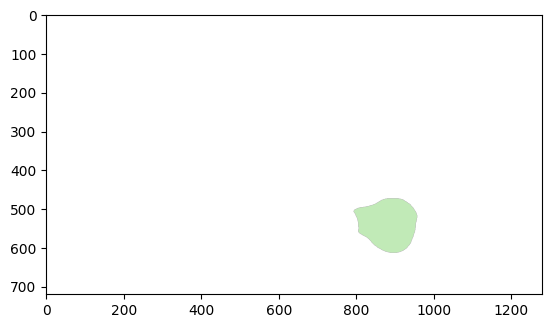

In [133]:
show_mask(masks[6].cpu().numpy(), plt.gca(), random_color=True)

(-0.5, 1279.5, 719.5, -0.5)

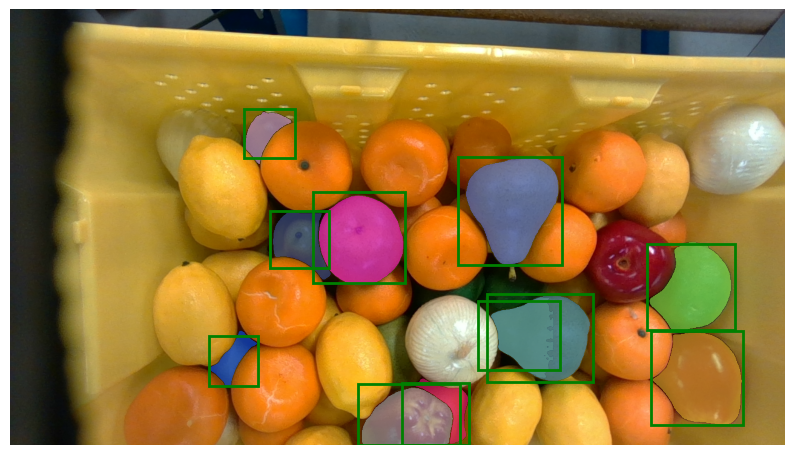

In [121]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in boxes:
    show_box(box, plt.gca())
plt.axis('off')
